# カロリメータに入射した粒子のエネルギー再構成

このノートブックでは、Geant4によりシミュレーションされたカロリメータに入射した粒子のエネルギー再構成を行う。

シミュレーションの詳細についてはM1の小林君の卒業論文を参考にすること。

In [1]:
import ROOT as r
import numpy as np
import pandas as pd

Welcome to JupyROOT 6.28/00


## ファイルのコピー
- まず、小林君のディレクトリから必要なファイルをコピーする。
- software_school_2023ごとコピーしていると思うので実行する必要はないが、一応載せておく。
- ファイルをコピーする歳には、事前にどれぐらいの大きさのファイルを転送するのかを確認しておくこと。

In [2]:
import subprocess

for i in range(2, 31, 2):
    subprocess.run([
        "rsync", # rsyncコマンド: ファイルを転送するコマンドで、既存のファイルを上書きせずに更新する
        "-va", # -v: 詳細を表示, -a: 権限やタイムスタンプを保持
        f"/home/kobayashik/geant4/pi_k_experiment/AHCAL/regression/energy1_30GeV/root_file/data_{i}GeV/pi.root",
        f"../data/calorimeter_data/pi_{i}GeV.root"
        ])

sending incremental file list

sent 64 bytes  received 12 bytes  152.00 bytes/sec
total size is 183,665,414  speedup is 2,416,650.18
sending incremental file list

sent 64 bytes  received 12 bytes  152.00 bytes/sec
total size is 324,756,656  speedup is 4,273,113.89
sending incremental file list

sent 65 bytes  received 12 bytes  154.00 bytes/sec
total size is 443,300,645  speedup is 5,757,151.23
sending incremental file list

sent 64 bytes  received 12 bytes  152.00 bytes/sec
total size is 566,847,786  speedup is 7,458,523.50
sending incremental file list

sent 65 bytes  received 12 bytes  154.00 bytes/sec
total size is 695,421,476  speedup is 9,031,447.74
sending incremental file list

sent 64 bytes  received 12 bytes  152.00 bytes/sec
total size is 823,066,374  speedup is 10,829,820.71
sending incremental file list

sent 64 bytes  received 12 bytes  152.00 bytes/sec
total size is 946,280,612  speedup is 12,451,060.68
sending incremental file list

sent 65 bytes  received 12 bytes  15

## ROOTファイルの中身を調べる

## TTree と Branch
TTreeとは、ROOTで変数データやオブジェクトをひとまとめにして管理するクラスのことである。

基本的にはTTree1つが1つの実験データを表しており、実験データの各変数はBranchという形式で登録されている。
Branchには`int`や`double`に加え、`vector`や`array`などの配列形式も登録できる。

### 参考
- [TTree Class Reference](https://root.cern.ch/doc/master/classTTree.html)
- [TBranch Class Refefence](https://root.cern.ch/doc/master/classTBranch.html)
- [Kamono Wiki | Ntuple](https://www-he.scphys.kyoto-u.ac.jp/member/n.kamo/wiki/doku.php?id=study:software:root:ntuple)

In [14]:
file = r.TFile("../data/calorimeter_data/pi_10GeV.root") # １つファイルを開いてみる
print(file.ls()) # ファイルの中身を表示

None
TFile**		../data/calorimeter_data/pi_10GeV.root	
 TFile*		../data/calorimeter_data/pi_10GeV.root	
  KEY: TTree	B4;1	Edep and TrackL
  KEY: TTree	Edep;1	Each Part Energy Deposit
  KEY: TTree	Gap_Edep;1	Detect Time in Gap
  KEY: TTree	Event_Condition;1	Event Condition
  KEY: TH1D	Eabs;1	Edep in absorber
  KEY: TH1D	Egap;1	Edep in gap
  KEY: TH1D	Labs;1	trackL in absorber
  KEY: TH1D	Lgap;1	trackL in gap


`../data/calorimeter_data/pi_10GeV.root`には`B4`や`Edep`といったTTreeが存在していることが確認できる。

今回は`B4`というTTreeを使って、カロリメータに入射した粒子のエネルギー再構成を行う。

In [4]:
ttree = file.Get("B4") # TTreeを取得
ttree.Print() # TTreeの中身(Branchとか)を表示

******************************************************************************
*Tree    :B4        : Edep and TrackL                                        *
*Entries :    10000 : Total =          604375 bytes  File  Size =     392132 *
*        :          : Tree compression factor =   1.55                       *
******************************************************************************
*Br    0 :Eabs      : Double_t B4                                            *
*Entries :    10000 : Total  Size=     120805 bytes  File Size  =      70825 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.36     *
*............................................................................*
*Br    1 :Egap      : Double_t B4                                            *
*Entries :    10000 : Total  Size=     120805 bytes  File Size  =      71171 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.35     *
*...................................................

上の情報から、以下のことがわかる
- `B4`というTTreeを読み込んでおり、イベント数（`Entries`）は`10000`である
- `B4`の中には`Eabs`, `Egap`,...といった全部で5つのBranchが存在している
- いずれのブランチに入っている変数も、データ型は`double`（倍精度浮動小数点）である

カロリメータに入射した粒子のエネルギー再構成を行うには、検出層(`Egap`)のエネルギーさえわかれば良い。

## RDataFrameに変換
このまま"Egap"のデータを取り出してヒストグラムを書いても良いが、ROOTにはRDataFrameという便利なクラスがあるためこれを利用する。


### [ROOT::RDataFrame Class Reference](https://root.cern/doc/master/classROOT_1_1RDataFrame.html)

ROOT's RDataFrame offers a modern, high-level interface for analysis of data stored in TTree , CSV and other data formats, in C++ or Python.

In addition, multi-threading and other low-level optimisations allow users to exploit all the resources available on their machines completely transparently.
Skip to the class reference or keep reading for the user guide.

In [15]:
rdf = r.RDataFrame("B4", "../data/calorimeter_data/pi_10GeV.root")
rdf.Describe()

Dataframe from TChain B4 in file ../data/calorimeter_data/pi_10GeV.root

Property                Value
--------                -----
Columns in total            5
Columns from defines        0
Event loops run             0
Processing slots            1

Column  Type            Origin
------  ----            ------
Eabs    Double_t        Dataset
Egap    Double_t        Dataset
Event   Double_t        Dataset
Labs    Double_t        Dataset
Lgap    Double_t        Dataset

RDataFrameは、pythonの外部ライブラリであるpandasのDataFrameに似た構造をしており、実際にpandasのDataFrameに変換することもできる。

In [6]:
df  = pd.DataFrame(rdf.AsNumpy())
df

,Eabs,Egap,Event,Labs,Lgap
0,8879.795822,217.222662,0.0,6500.328841,821.744534
1,7435.570641,320.249247,1.0,4447.496350,686.294965
2,8999.297494,266.591659,2.0,6371.085690,975.789887
3,7890.535676,256.847169,3.0,5145.899765,767.572448
4,8932.095120,241.490799,4.0,6703.921449,940.038332
...,...,...,...,...,...
9995,7909.485203,337.832696,9995.0,5197.211286,713.047264
9996,8147.024721,228.870277,9996.0,5339.609168,667.634452
9997,8172.893373,266.689759,9997.0,4438.488691,666.290054
9998,8301.594848,260.156141,9998.0,5437.677684,782.195160


## RdataFrame.Histo1Dによるヒストグラムの描画とガウスフィッティング

In [7]:
# ヒストグラムとフィット関数の作成
h1_list = []
f1_list = []
for i in range(15):
    energy_gev = (i+1)*2 # 2, 4, 6, ..., 30
    rdf_tmp = r.RDataFrame("B4", f"../data/calorimeter_data/pi_{energy_gev}GeV.root")
    h1_tmp = rdf_tmp.Histo1D( 
        (
            f"h1_{energy_gev}GeV", # ヒストグラムの名前空間上での名前
            "", # ヒストグラムのタイトル
            1000, # ビンの数
            0, # x軸の最小値
            2000 # x軸の最大値
         ), # TH1D作成時と同じ引数
        "Egap" # Branch名の指定
    ) # ヒストグラム(TH1D)の作成
    h1_tmp.GetXaxis().SetTitle("Energy Deposit(MeV)") # x軸のラベルの設定
    h1_tmp.GetYaxis().SetTitle("Entry") # y軸のラベルの設定
    f1_tmp = r.TF1(
        f"f1_{energy_gev}GeV", # フィット関数の名前空間上での名前
        "gaus", # フィット関数の関数系。ここではガウス関数を指定している
        0, # x軸の最小値
        2000 # x軸の最大値
    ) # フィット関数(TF1)の作成
    h1_tmp.Fit(f1_tmp) # フィット関数の適用
    h1_list.append(h1_tmp) # ヒストグラムをリストに追加
    f1_list.append(f1_tmp) # フィット関数をリストに追加
print("TH1D:", len(h1_list), " TF1:", len(f1_list)) # リストに詰められたTH1DとTF1の数を確認

TH1D: 15  TF1: 15
 FCN=884.762 FROM MIGRAD    STATUS=CONVERGED      86 CALLS          87 TOTAL
                     EDM=5.16162e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     5.08072e+02   7.05907e+00   7.73335e-02  -1.81651e-05
   2  Mean         5.55153e+01   1.90002e-01   2.19472e-03   1.24922e-04
   3  Sigma        1.43317e+01   1.31882e-01   2.48737e-05  -2.82829e-02
 FCN=851.858 FROM MIGRAD    STATUS=CONVERGED      85 CALLS          86 TOTAL
                     EDM=1.09807e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.27980e+02   4.76354e+00   4.89005e-02   2.47201e-06
   2  Mean         1.08263e+02   2.72594e-01   3.32014e-03   4.43848e-05
   3  Sigma    

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


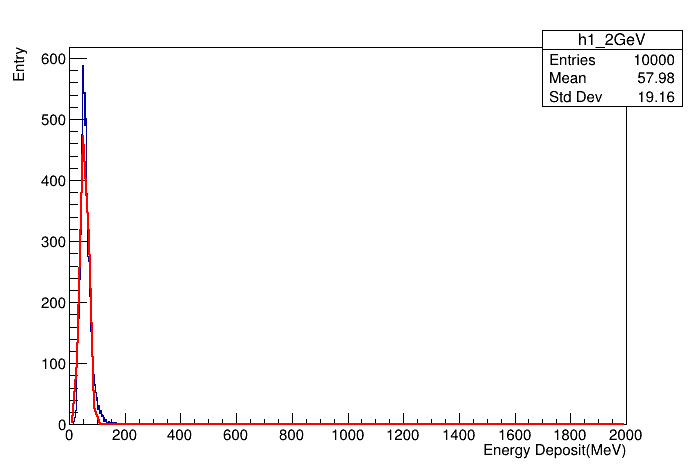

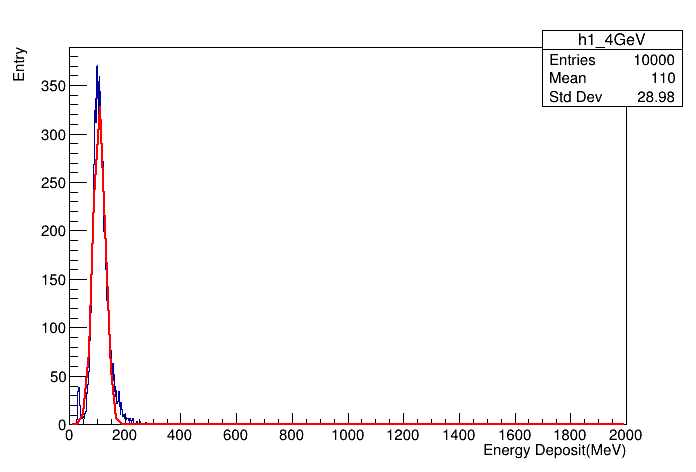

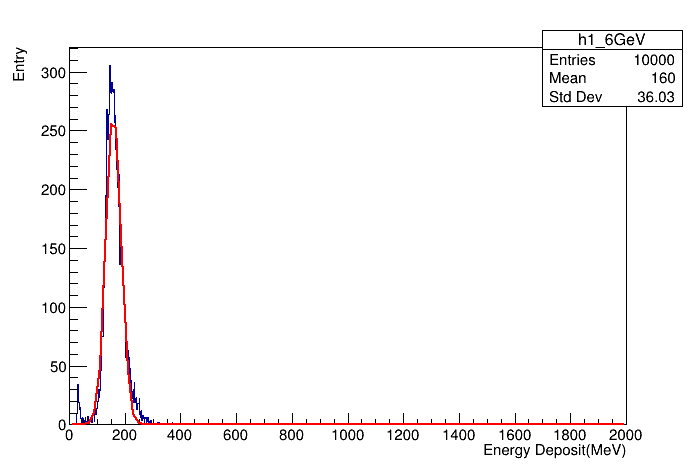

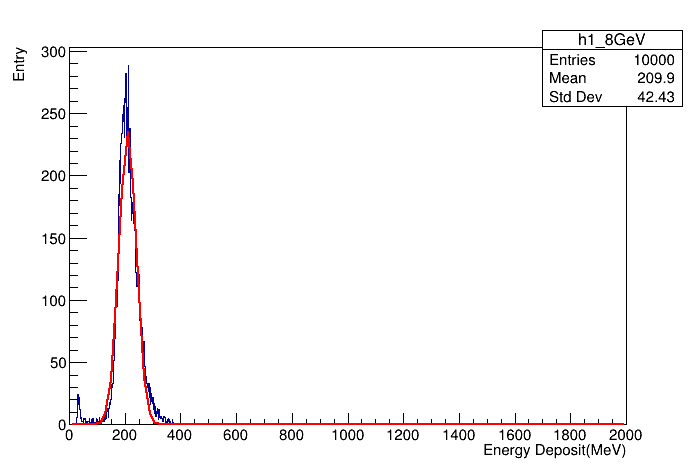

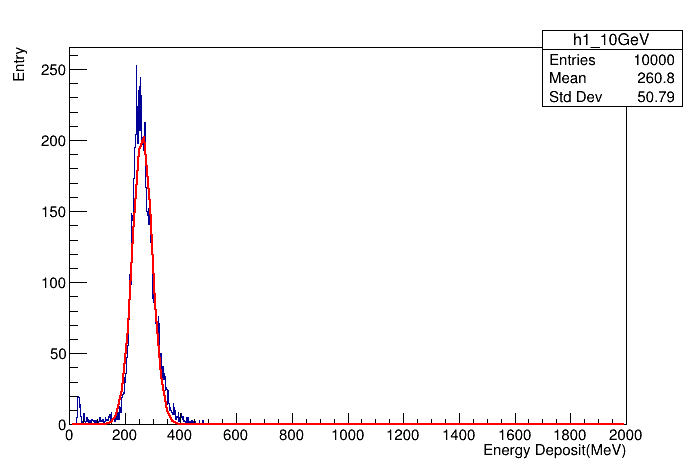

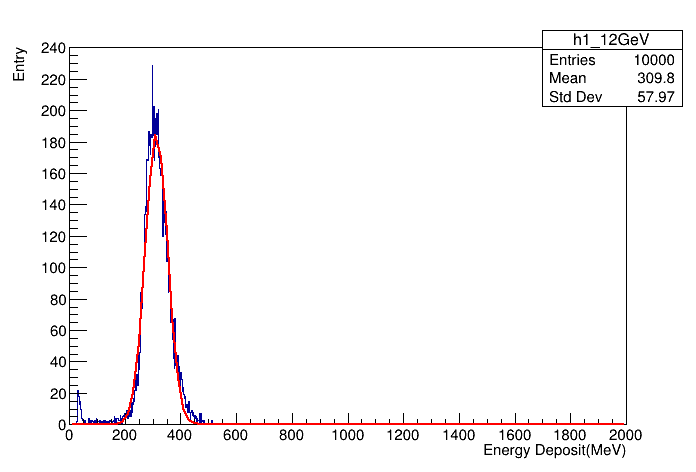

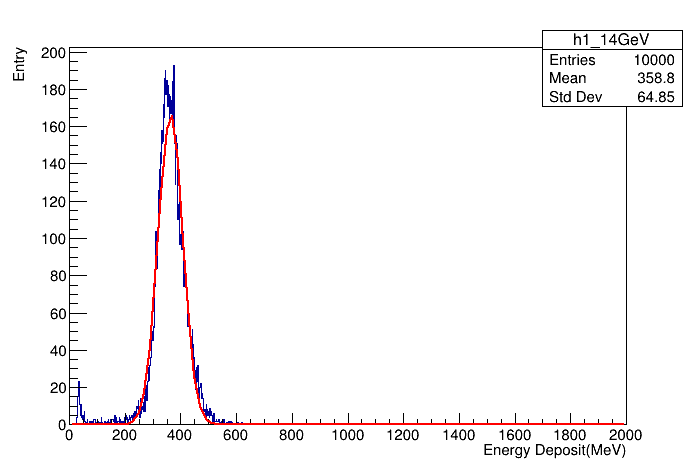

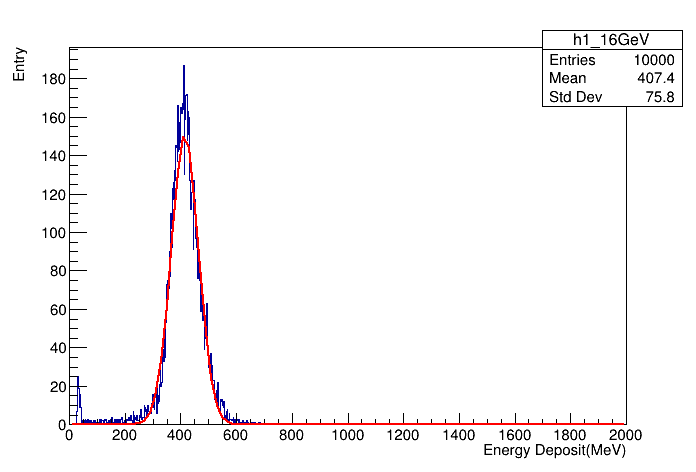

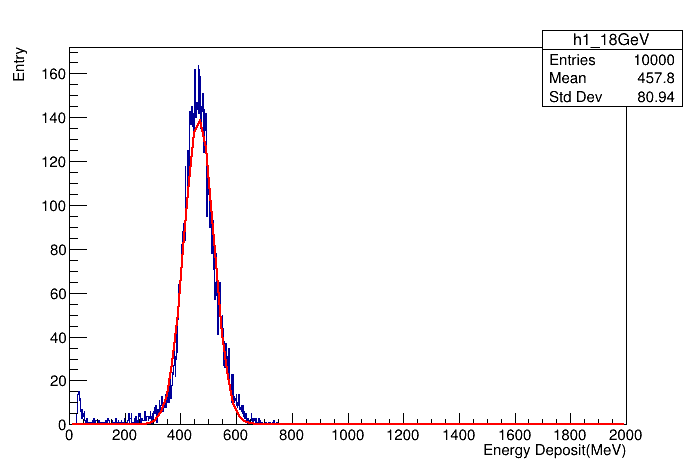

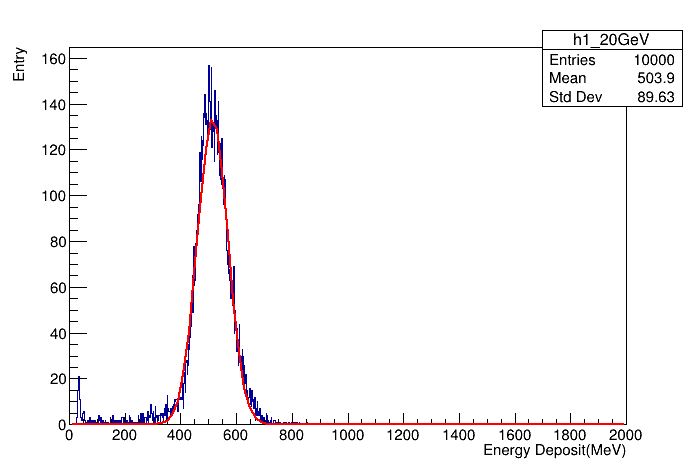

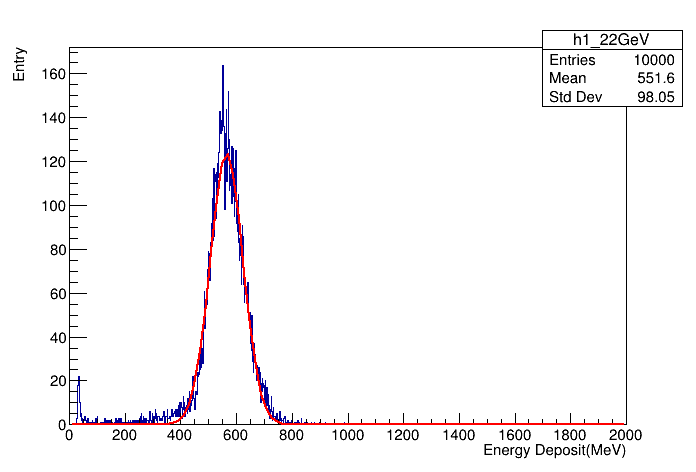

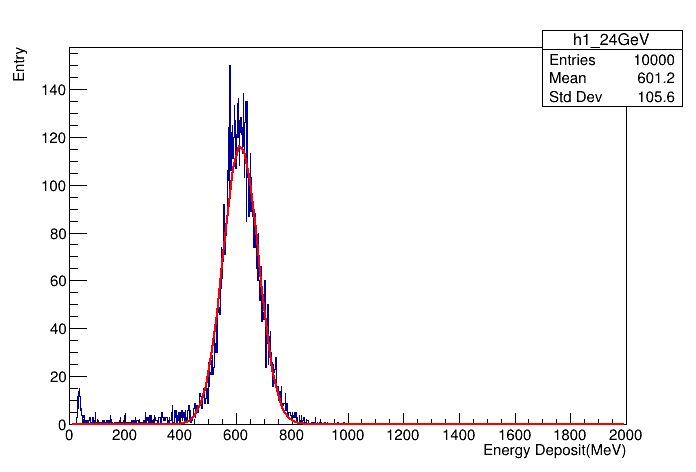

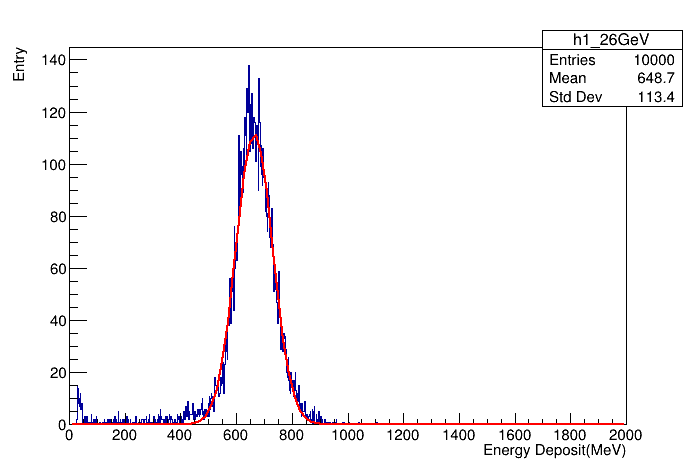

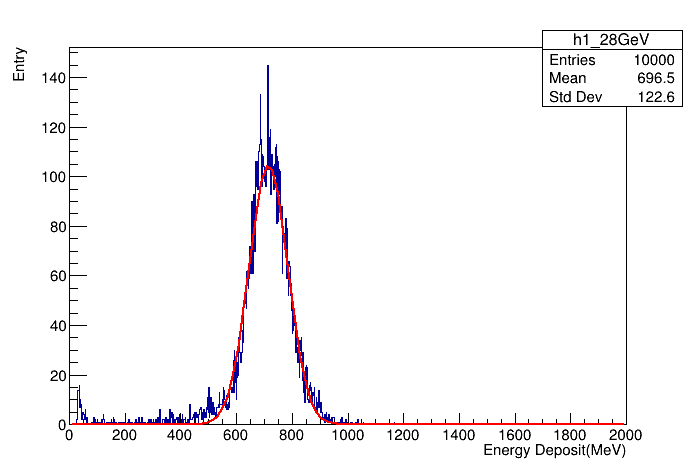

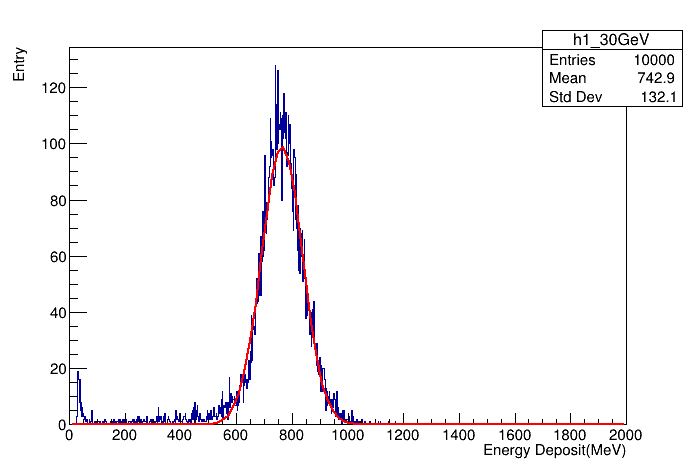

In [8]:
# 作成したヒストグラムとフィット関数を表示する
for i in range(15):
    cname = f"c_egap{i}"
    exec(f"c_egap{i} = r.TCanvas(cname)") # TCanvasの作成
    h1_list[i].Draw("HIST") # ヒストグラムの描画
    f1_list[i].Draw("same") # フィット関数の描画
    exec(f"c_egap{i}.Draw()") # TCanvasの描画

## フィット関数から平均と標準偏差を取得し、グラフにプロット

In [9]:
# 平均と標準偏差の取得
mean_list = []
sigma_list = []
for i in range(15):
    mean_list.append(f1_list[i].GetParameter(1)) # 平均
    sigma_list.append(f1_list[i].GetParameter(2)) # 標準偏差

# MeVからGeVへの変換とndarrayへの変換
mean_list = np.array(mean_list)/1000
sigma_list = np.array(sigma_list)/1000
print("mean_list:", mean_list)
print("sigma_list", sigma_list)

mean_list: [0.05551534 0.10826335 0.15950662 0.21051704 0.26292393 0.31365397
 0.36430523 0.41582582 0.46616734 0.51568001 0.5659907  0.6163959
 0.66574323 0.71645288 0.7650438 ]
sigma_list [0.01433172 0.02225656 0.0267542  0.03108005 0.03540687 0.04001294
 0.04442198 0.04917458 0.05367066 0.05549046 0.05940938 0.0632088
 0.06627731 0.06964232 0.07391685]


In [11]:
# 平均と標準偏差の誤差を取得
meanerror_list = []
sigmaerror_list = []
for i in range(15):
    meanerror_list.append(f1_list[i].GetParError(1)) # 平均を取得
    sigmaerror_list.append(f1_list[i].GetParError(2)) # 標準偏差を取得

# MeVからGeVへの変換とndarrayへの変換
meanerror_list = np.array(meanerror_list)/1000
sigmaerror_list = np.array(sigmaerror_list)/1000
print("meanerror_list:", meanerror_list)
print("sigmaerror_list", sigmaerror_list)

meanerror_list: [0.00019    0.00027259 0.00032515 0.00037692 0.00042012 0.000453
 0.0004918  0.00053014 0.00057225 0.00058839 0.00062842 0.00066783
 0.00069654 0.00073116 0.00077479]
sigmaerror_list [0.00013188 0.00022448 0.00025975 0.00030253 0.00033889 0.00037072
 0.00042815 0.00047589 0.00050723 0.00051022 0.00054738 0.00058789
 0.00060995 0.00067015 0.00069685]


 FCN=225.792 FROM MIGRAD    STATUS=CONVERGED      55 CALLS          56 TOTAL
                     EDM=1.95772e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.92577e+01   2.05059e-02   9.74551e-05   3.35450e-04
   2  p1          -2.34506e-01   6.32583e-03   3.00636e-05   1.33682e-04


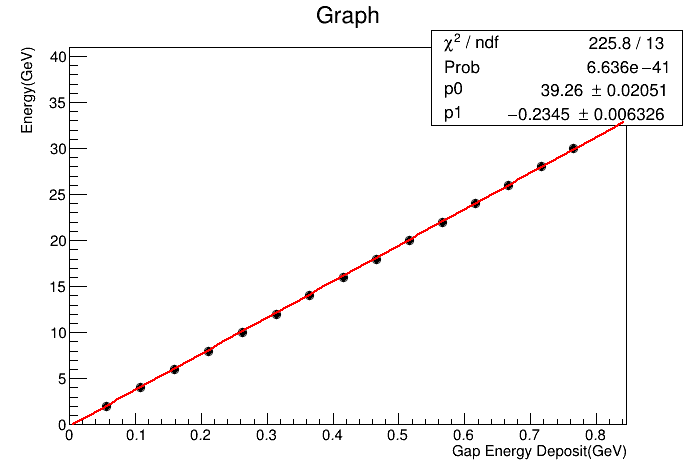

In [12]:
# 入射エネルギーとEgapの平均を誤差棒付きでプロット
c_true_gap = r.TCanvas("c_true_gap")
g1_true_gap = r.TGraphErrors(
    len(mean_list), # データ数
    mean_list.astype(np.float32), # x軸のデータ
    ((np.arange(15)+1)*2).astype(np.float32), # y軸のデータ
    meanerror_list.astype(np.float32), # x軸の誤差
    np.zeros(15).astype(np.float32) # y軸の誤差
) # TGraphErrors(誤差棒付きプロット)の作成
# g1_true_gapの体裁を整える
g1_true_gap.SetMarkerStyle(20) # マーカーの形を変更
g1_true_gap.SetMarkerSize(1) # マーカーの大きさを変更
g1_true_gap.GetYaxis().SetTitle("Energy(GeV)") # y軸のラベルの設定
g1_true_gap.GetXaxis().SetTitle("Gap Energy Deposit(GeV)") # x軸のラベルの設定
g1_true_gap.GetYaxis().SetRangeUser(0, 41) # y軸の表示範囲の設定
g1_true_gap.GetXaxis().SetRangeUser(0, 0.9) # x軸の表示範囲の設定

# 直線フィット
f1_true_gap = r.TF1("f1_true_gap", "[0]*x+[1]", 0, 1500) # フィット関数の作成
f1_true_gap.SetParameter(0, 2/mean_list[0]) # フィット関数のパラメータの初期値を設定
g1_true_gap.Fit(f1_true_gap) # フィット関数の適用

r.gStyle.SetOptFit(1111) # フィッティングの結果を表示する設定

g1_true_gap.Draw("AP") # プロットの描画
f1_true_gap.Draw("same") # フィット関数の描画
c_true_gap.Draw() # TCanvasの描画

このグラフから傾きと切片を取り出せれば、Egapのが値から入射エネルギーを再構成できる

In [13]:
# f1_true_gapから傾きと切片を取得
slope = f1_true_gap.GetParameter(0) # 傾き
slice = f1_true_gap.GetParameter(1) # 切片
print("傾き=", slope, " 切片=", slice)

傾き= 39.25765055771978  切片= -0.2345060872748099


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_rec_true


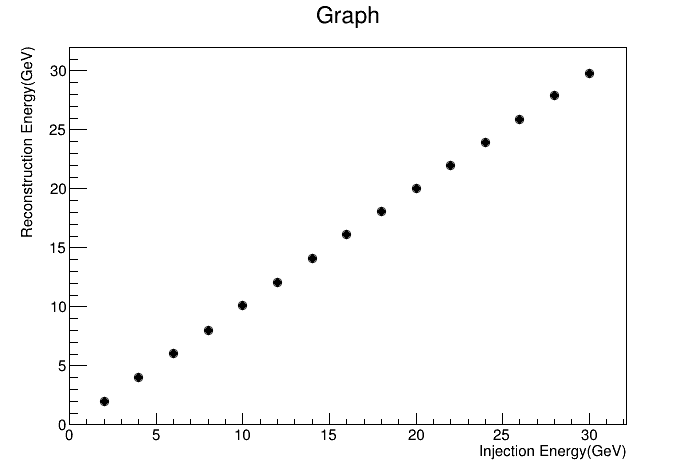

In [31]:
# 傾きと切片からエネルギーを再構成
c_rec_true = r.TCanvas("c_rec_true")
g1_rec_true = r.TGraph(
    len(mean_list),
    ((np.arange(15)+1)*2).astype(np.float32),
    (mean_list*slope+slice).astype(np.float32),
)

# g1_rec_trueの体裁を整える
g1_rec_true.SetMarkerStyle(20)
g1_rec_true.SetMarkerSize(1)
g1_rec_true.GetXaxis().SetTitle("Injection Energy(GeV)")
g1_rec_true.GetYaxis().SetTitle("Reconstruction Energy(GeV)")
g1_rec_true.GetXaxis().SetRangeUser(0, 32)
g1_rec_true.GetYaxis().SetRangeUser(0, 32)

g1_rec_true.Draw("AP")
c_rec_true.Draw()

# カロリメータのエネルギー分解能

カロリメータの精度を示すエネルギー分解能(Energy Resolution)を求める

In [32]:
# エネルギー分解能の計算
resolution = sigma_list/mean_list
resolutionerror = np.sqrt(np.power(resolution*meanerror_list/mean_list, 2) + np.power(resolution*sigmaerror_list/sigma_list, 2))

 FCN=42.0694 FROM MIGRAD    STATUS=CONVERGED      40 CALLS          41 TOTAL
                     EDM=6.4467e-20    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.16597e-01   3.49976e-03   3.62696e-06  -9.79529e-08
   2  p1           3.77795e-02   9.14906e-04   9.48159e-07   1.87348e-08


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_resolution


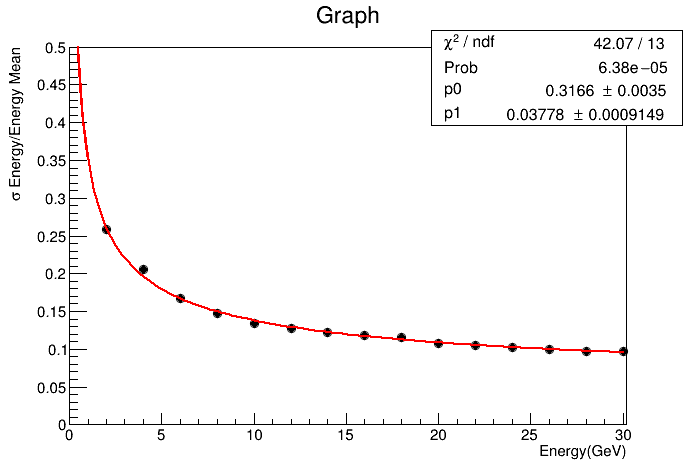

In [35]:
# エネルギー分解能のプロット
c_resolution = r.TCanvas("c_resolution")
g1_resolution = r.TGraphErrors(
    len(resolution),
    ((np.arange(15)+1)*2).astype(np.float32),
    resolution.astype(np.float32),
    np.zeros(len(resolution)).astype(np.float32),
    resolutionerror.astype(np.float32))

# g1_resoltionの体裁を整える
g1_resolution.SetMarkerStyle(20)
g1_resolution.SetMarkerSize(1)
g1_resolution.GetYaxis().SetRangeUser(0, 0.5)
g1_resolution.GetXaxis().SetRangeUser(0, 30)
g1_resolution.GetXaxis().SetTitle("Energy(GeV)")
g1_resolution.GetYaxis().SetTitle("#sigma Energy/Energy Mean")

# g1_resolutionにフィティング
f1_resolution = r.TF1("f1_resolution", "[0]/sqrt(x)+[1]")
g1_resolution.Fit("f1_resolution")

# フィッティングの結果を表示する設定
r.gStyle.SetOptFit(1111)

g1_resolution.Draw("AP")
f1_resolution.Draw("same")
c_resolution.Draw()